In [210]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import nltk
from IPython.display import display_html 
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import pickle

In [13]:
df = pd.read_csv("sms_spam.csv")

In [14]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [15]:
df.shape

(5572, 5)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB



# 1. Cleaning Data

In [17]:
#Drop unnecessary columns
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [18]:
df.sample(10)

,v1,v2
1517,spam,Our brand new mobile music service is now live...
884,ham,Yoyyooo u know how to change permissions for a...
1991,ham,No other Valentines huh? The proof is on your ...
2303,ham,Should I tell my friend not to come round til ...
140,ham,"K, text me when you're on the way"
5040,ham,She ran off with a younger man. we will make p...
846,ham,My stomach has been thru so much trauma I swea...
799,ham,"\Gimme a few\"" was &lt;#&gt; minutes ago"""
1844,ham,Da is good good player.why he is unsold.
3546,spam,Rock yr chik. Get 100's of filthy films &XXX p...


In [20]:
# Renaming the columns
df.rename(columns={"v1": "target", "v2":"sms"}, inplace=True)
df.sample(5)

,target,sms
4543,ham,when you and derek done with class?
1314,ham,Got but got 2 colours lor. One colour is quite...
4342,ham,Its a valentine game. . . send dis msg to all ...
374,spam,"Thanks for your Ringtone Order, Reference T91...."
3022,ham,You are a very very very very bad girl. Or lady.


In [25]:
# Converting 'spam' and 'ham' to numbers
encoder = LabelEncoder()
df["target"] = encoder.fit_transform(df["target"])

In [27]:
df.sample(5)

,target,sms
109,0,Dont worry. I guess he's busy.
1441,0,Ya:)going for restaurant..
541,0,A famous quote : when you develop the ability ...
600,0,Mind blastin.. No more Tsunamis will occur fro...
5096,0,But i'm really really broke oh. No amount is t...


In [30]:
encoder.classes_

array(['ham', 'spam'], dtype=object)

In [31]:
# check for missing values
df.isnull().sum()

target    0
sms       0
dtype: int64

In [32]:
# check for duplicate 
df.duplicated().sum()

403

In [33]:
# drop duplicates
df.drop_duplicates(keep="first")
df.duplicated().sum()

403

# 2. EDA

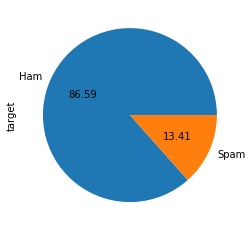

In [41]:
df['target'].value_counts().plot(kind="pie", labels=["Ham", "Spam"], autopct="%0.2f");

In [43]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
df.head()

,target,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [46]:
df["num_chars"] = df["sms"].apply(len)

In [47]:
df.head()

,target,sms,num_chars
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [50]:
df["num_words"] = df["sms"].apply(lambda x: len(nltk.word_tokenize(x)))

In [51]:
df["num_sentences"] = df["sms"].apply(lambda x: len(nltk.sent_tokenize(x)))

In [52]:
df.head()

,target,sms,num_chars,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [53]:
df[["num_chars", "num_words", "num_sentences"]].describe()

,num_chars,num_words,num_sentences
count,5572.000000,5572.000000,5572.000000
mean,80.058327,18.697057,1.972182
std,59.623937,13.743872,1.420084
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,121.000000,27.000000,2.000000
max,910.000000,220.000000,28.000000


In [74]:
df1 = df[df["target"] == 0].describe()
df2 = df[df["target"] == 1].describe()
df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption("Ham Sms")
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption("Spam Sms")
display_html(df1_styler._repr_html_() + " " + df2_styler._repr_html_(), raw=True)

,target,num_chars,num_words,num_sentences
count,4825.000000,4825.000000,4825.000000,4825.000000
mean,0.000000,71.021347,17.271917,1.808705
std,0.000000,58.014768,13.988885,1.328227
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,33.000000,8.000000,1.000000
50%,0.000000,52.000000,13.000000,1.000000
75%,0.000000,92.000000,22.000000,2.000000
max,0.000000,910.000000,220.000000,28.000000
,target,num_chars,num_words,num_sentences
count,747.000000,747.000000,747.000000,747.000000


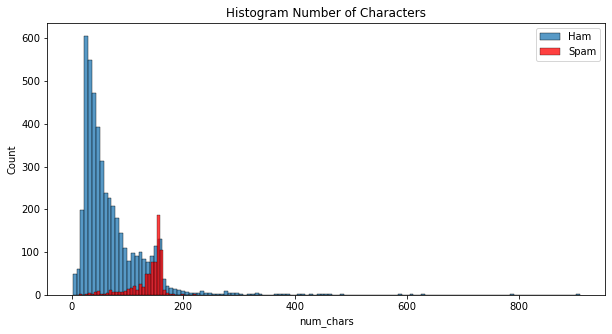

In [91]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df["target"] == 0]["num_chars"])
sns.histplot(df[df["target"] == 1]["num_chars"], color="red")
plt.legend(["Ham", "Spam"])
plt.title("Histogram Number of Characters");

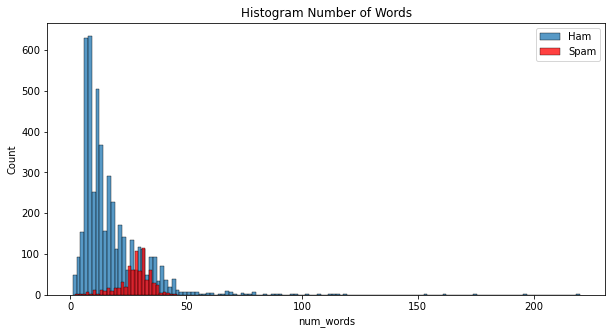

In [92]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df["target"] == 0]["num_words"])
sns.histplot(df[df["target"] == 1]["num_words"], color="red")
plt.legend(["Ham", "Spam"])
plt.title("Histogram Number of Words");

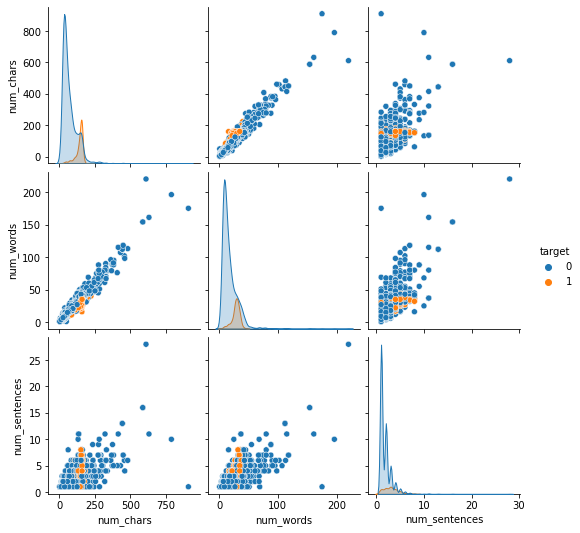

In [94]:
sns.pairplot(df, hue="target")

<AxesSubplot:>

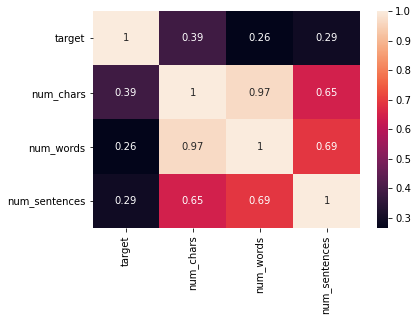

In [97]:
sns.heatmap(df.corr(), annot=True)

# 3. Data Preprocessing

In [122]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [w for w in text if w.isalnum()]
    text = [w for w in text if w not in stopwords.words("english")]
    text = [w for w in text if w not in string.punctuation]
    ps = PorterStemmer()
    text = [ps.stem(w) for w in text ]
    return " ".join(text)

In [126]:
transform_text("Hey! alien #2736 && from the burning sun.")

'hey alien 2736 burn sun'

In [129]:
df["transformed_text"] = df["sms"].apply(transform_text)

In [132]:
df.sample(5)

,target,sms,num_chars,num_words,num_sentences,transformed_text
837,0,"Sir, I have been late in paying rent for the p...",372,89,5,sir late pay rent past month pay lt gt charg f...
529,0,Jay says that you're a double-faggot,36,7,1,jay say
3875,0,did u get that message,22,5,1,u get messag
3048,0,Lol they don't know about my awesome phone. I ...,85,20,2,lol know awesom phone could click delet right ...
1603,0,Have you heard about that job? I'm going to th...,143,31,4,heard job go wildlif talk tonight u want2com t...


In [139]:
wc = WordCloud(width=1000, height=500, min_font_size=10, background_color="white")

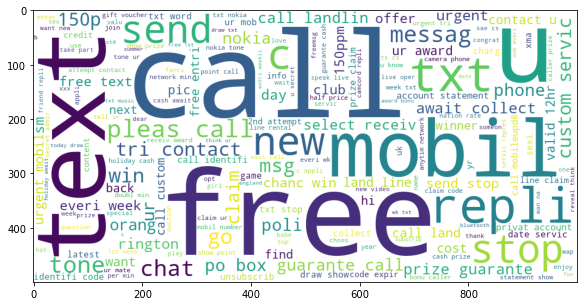

In [146]:
spam_wc = wc.generate(df[df["target"] == 1]["transformed_text"].str.cat(sep=" "))
plt.figure(figsize=(10, 5))
plt.imshow(spam_wc);

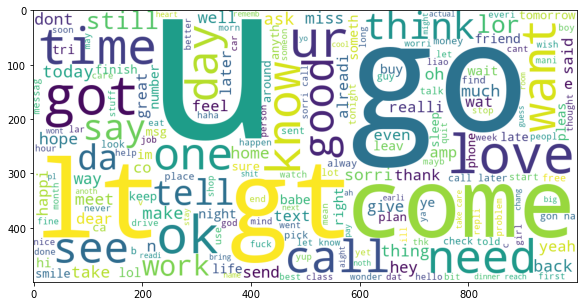

In [147]:
ham_wc = wc.generate(df[df["target"] == 0]["transformed_text"].str.cat(sep=" "))
plt.figure(figsize=(10, 5))
plt.imshow(ham_wc);

In [149]:
# Get top occuring words from each category

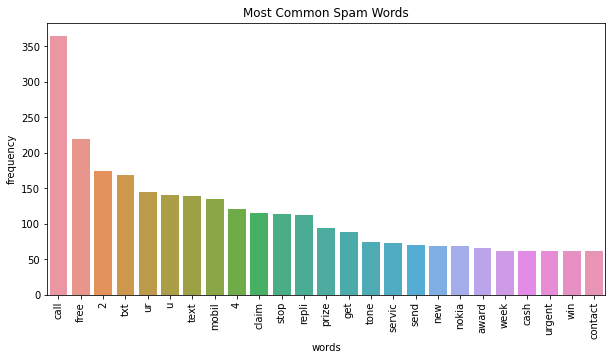

In [164]:
plt.figure(figsize=(10, 5))
spam_words = [word for sent in df[df['target'] == 1]["transformed_text"].tolist() for word in sent.split(" ")]
sns.barplot(data = pd.DataFrame(Counter(spam_words).most_common(25)),
           x=0,
           y=1)
plt.title("Most Common Spam Words")
plt.xlabel("words")
plt.ylabel("frequency")
plt.xticks(rotation='vertical');

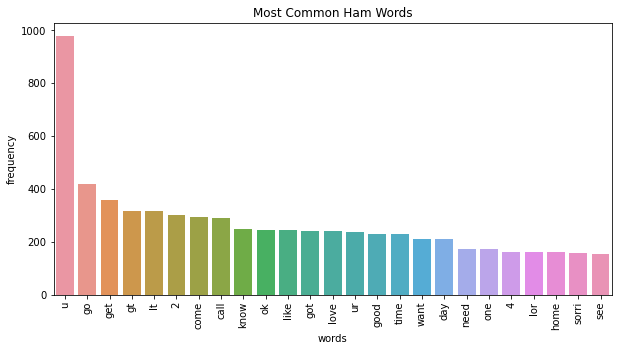

In [165]:
plt.figure(figsize=(10, 5))
ham_words = [word for sent in df[df['target'] == 0]["transformed_text"].tolist() for word in sent.split(" ")]
sns.barplot(data = pd.DataFrame(Counter(ham_words).most_common(25)),
           x=0,
           y=1)
plt.title("Most Common Ham Words")
plt.xlabel("words")
plt.ylabel("frequency")
plt.xticks(rotation='vertical');

# 4. Model Building

In [177]:
cv = CountVectorizer()
X = cv.fit_transform(df["transformed_text"]).toarray()

In [178]:
X.shape

(5572, 6677)

In [179]:
y = df["target"].values

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [205]:
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}

for m_name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"Model: {m_name}")
    print(f"Accuracy Score : {accuracy_score(y_test, pred)}")
    print(f"Precision Score : {precision_score(y_test, pred)}")    
    print(f"Confusion Matrix : \n{confusion_matrix(y_test, pred)}")
    print("\n")

Model: GaussianNB
Accuracy Score : 0.8699551569506726
Precision Score : 0.48863636363636365
Confusion Matrix : 
[[841 135]
 [ 10 129]]


Model: MultinomialNB
Accuracy Score : 0.979372197309417
Precision Score : 0.8972602739726028
Confusion Matrix : 
[[961  15]
 [  8 131]]


Model: BernoulliNB
Accuracy Score : 0.9775784753363229
Precision Score : 0.975
Confusion Matrix : 
[[973   3]
 [ 22 117]]




In [215]:
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}

vectorizers = {
    "Count Vectorizer": CountVectorizer(),
    "TFidf Vectorizer": TfidfVectorizer()
}

for m_name, model in models.items():
    for v_name, vectorizer in vectorizers.items(): 
        X = vectorizer.fit_transform(df["transformed_text"]).toarray()   
        y = df["target"].values 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print(f"Model : {m_name}")
        print(f"Vectorizer : {v_name}" )
        print(f"Accuracy Score : {accuracy_score(y_test, pred)}")
        print(f"Precision Score : {precision_score(y_test, pred)}")    
        print(f"Confusion Matrix : \n{confusion_matrix(y_test, pred)}")
        print("\n")

Model : GaussianNB
Vectorizer : Count Vectorizer
Accuracy Score : 0.8699551569506726
Precision Score : 0.48863636363636365
Confusion Matrix : 
[[841 135]
 [ 10 129]]


Model : GaussianNB
Vectorizer : TFidf Vectorizer
Accuracy Score : 0.8618834080717489
Precision Score : 0.47104247104247104
Confusion Matrix : 
[[839 137]
 [ 17 122]]


Model : MultinomialNB
Vectorizer : Count Vectorizer
Accuracy Score : 0.979372197309417
Precision Score : 0.8972602739726028
Confusion Matrix : 
[[961  15]
 [  8 131]]


Model : MultinomialNB
Vectorizer : TFidf Vectorizer
Accuracy Score : 0.9766816143497757
Precision Score : 0.991304347826087
Confusion Matrix : 
[[975   1]
 [ 25 114]]


Model : BernoulliNB
Vectorizer : Count Vectorizer
Accuracy Score : 0.9775784753363229
Precision Score : 0.975
Confusion Matrix : 
[[973   3]
 [ 22 117]]


Model : BernoulliNB
Vectorizer : TFidf Vectorizer
Accuracy Score : 0.9775784753363229
Precision Score : 0.975
Confusion Matrix : 
[[973   3]
 [ 22 117]]




## Final Steps

In [214]:
tfidf = TfidfVectorizer().fit(df["transformed_text"])
model = MultinomialNB().fit(X_train, y_train)

pickle.dump(tfidf, open("vectorizer.pkl", "wb"))
pickle.dump(model, open("model.pkl", "wb"))